This first chunk of code is designed to import dependencies, and explore the climate database 'hawaii.sqlite' through SQL Alchemy.

In [2]:
# IMPORTING DEPENDENCIES
%matplotlib inline
    
from matplotlib import style
style.use('fivethirtyeight')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
# PYTHON SQL TOOLKIT AND OBJECT RELATIONAL MAPPER
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import or_, and_, desc

In [4]:
# defining sqlite database path
db_path = "resources/hawaii.sqlite"

# creating engine
engine = create_engine(f"sqlite:///{db_path}")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)

In [6]:
# view all of the classes (tables) that automap found
Classes = base.classes.keys()

In [7]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [8]:
 # Create our session (link) from Python to the DB
session = Session(engine)

This next chunk of code is designed to:

    - Design a query to retrieve the last 12 months of precipitation data.


    - Select only the date and prcp values.


    - Load the query results into a Pandas DataFrame and set the index to the date column.


    - Sort the DataFrame values by date.


    - Plot the results using the DataFrame plot method.

    - Use Pandas to print the summary statistics for the precipitation data.

In [12]:
# inspecting the tables (Classes) and column names from the database
inspector = inspect(engine)

# for loop to print table names and get their columns
for Class in Classes:
    
    print(Class)
    
    columns = inspector.get_columns(Class)
    
    # for loop to print the columns and data types for each
    # table
    for column in columns:
        
        print(column["name"], column["type"])
        
    # for readability purposes
    print()

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# getting latest date
last_date_recorded = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# last_date_recorded = '2017-08-23'

# getting one year from the last date recorded
year_from_last_date = dt.datetime(2017, 8, 23) - dt.timedelta(days = 365)

# query for date and precipitation data for all days on and after 'year_from_last_date'
prcp_query = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_from_last_date).\
            order_by(Measurement.date).\
            all()
    
# creating dataframe of query results with column names corresponding to
# the values in respective columns
prcp_df = pd.DataFrame(prcp_query, columns = ['Date', 'Precipitation'])

# filling nan values with zero
prcp_df.fillna(0)

# setting index to date
prcp_df.set_index(prcp_df['Date'], inplace = True)

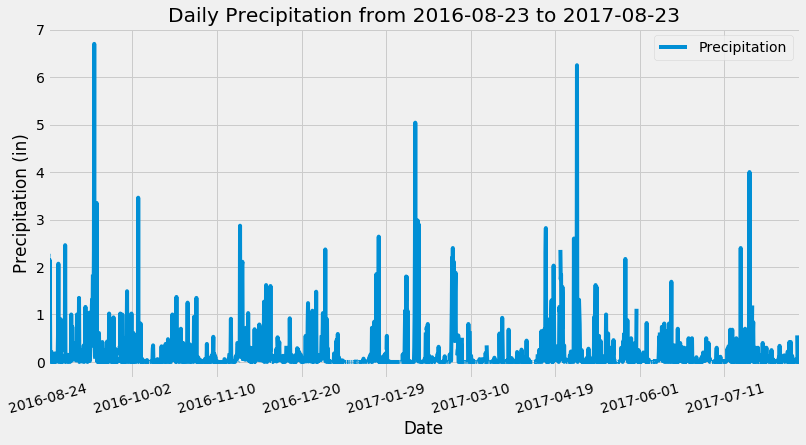

In [99]:
# plotting precipitation 
prcp_df.plot('Date', 'Precipitation', figsize = (12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Daily Precipitation from 2016-08-23 to 2017-08-23")
plt.legend(["Precipitation"])
plt.xticks(rotation = 15)
plt.show()

In [100]:

# printing summary statistics for precipitation data
print(prcp_df.describe())

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


This next chunk of code is meant to: 

- Design a query to calculate the total number of stations.

- Design a query to find the most active stations.

- List the stations and observation counts in descending order.

- Which station has the highest number of observations?

- Design a query to retrieve the last 12 months of temperature observation data (tobs).

- Filter by the station with the highest number of observations.

- Plot the results as a histogram with bins = 12.

In [101]:
# query to calculate total number of stations, sets result to variable 'total_stations'
# and prints results using an f string
total_stations = session.query(Station.station).count()

print(f"The total number of stations is: {total_stations}") 

The total number of stations is: 9


In [102]:
# group by measurement.station to find count of each station record from the measurements table
# listing the observation counts in descending order to find most active stations
observation_query = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(desc(func.count(Measurement.station)))

# putting query results in data frame
ob_count_df = pd.DataFrame(observation_query, columns = ['Station', 'Number_of_Records'])

# finding station with the most records
highest_obs_count_station = ob_count_df['Station'][0]

# printing out the highest observation station
print(f"The station with the highest record count is: {highest_obs_count_station}")

# showing dataframe
ob_count_df

The station with the highest record count is: USC00519281


,Station,Number_of_Records
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


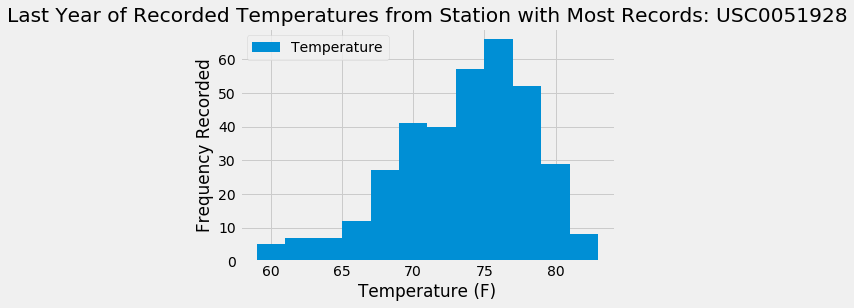

In [103]:
# query to get last twelve months of temperature data called 'temp_query'
# filtering by the station with the highest number of observations
# ################ NEEDS CHECK
temp_query = session.query(Measurement.tobs).\
            filter(Measurement.date >= year_from_last_date, Measurement.station == highest_obs_count_station).\
            all()

temp_df = pd.DataFrame(temp_query, columns = ['Temperature'])
    
# plotting results using histogram with 12 bins and labeling respective plot areas
temp_df.plot(kind = 'hist', bins = 12)
plt.title('Last Year of Recorded Temperatures from Station with Most Records: USC0051928')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency Recorded')
plt.show()